In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import norm
from scipy.integrate import cumulative_trapezoid

# Fitting a Gaussian Mixture (in 1-dimension) Using Expectation Maximization (EM)

Consider $\vec{X}$, a set of $N$ samples from a mixture of $M$ different Gaussian distributions where the proportion of the sample contributed from each individual Gaussian is not known a priori. The pdf for this distribution is:

$P(\vec{X} | \hat{\theta}) = \sum_{j=1}^{M} \pi_j P_j(\vec{X} | \sigma_j, \mu_j)$

where $\pi_j$ is the proportion of the sample from Gaussian $j$, subject to the constraint:

$\sum_{j=1}^{M} \pi_j = 1$

and $P_j$ is the pdf of Gaussian $j$ with standard deviation $\sigma_j$ and mean $\mu_j$:

$P_j(\vec{X} | \sigma_j, \mu_j) = \frac{1}{\sqrt{2 \pi {\sigma_j}^2}} e^{\frac{-(\vec{X} - \mu_j)^2}{2 {\sigma_j}^2}}$

Let's define this pdf with a smattering of peaks. If the Gaussians don't significantly overlap, the problem is trivial and the EM is overkill. If the peaks overlap too much, there's not enough information to distinguish them. I tried to generate overlapping Gaussians.

In [2]:
N_gaussians = 10
N_samples = 10000

random_pis = .2 + np.random.random(N_gaussians)
random_pis = random_pis / random_pis.sum()
random_mus = np.linspace(150., 850., N_gaussians) + norm.rvs(loc = 0, scale = 30, size = N_gaussians)
random_sigs = norm.rvs(loc = 30, scale = 5, size = N_gaussians)

def gaussian_array(X: np.ndarray, mus: np.ndarray, sigs: np.ndarray) -> np.ndarray:
    '''Function which returns a rank 2 numpy array of the probability density at an array
    of different means and standard-deviations. The returned array is of shape:
    (size(X), size(mus|sigs))
    '''
    return np.exp(-np.power(X[:,np.newaxis] - mus, 2.) / (2 * np.power(sigs, 2.))) / np.sqrt(2 * np.pi) / sigs


def sum_of_gaussians(X: np.ndarray, 
                     pis: np.ndarray, 
                     mus: np.ndarray, 
                     sigs: np.ndarray) -> np.ndarray:
    '''Sum of gaussians with different proportions: pis
    with means: mus and standard deviations: sigs.

    If the sum of all the pis is 1 this is a normalized pdf.
    '''
    return (pis * gaussian_array(X, mus, sigs)).sum(axis=1)

Now let's draw some random values from the pdf.

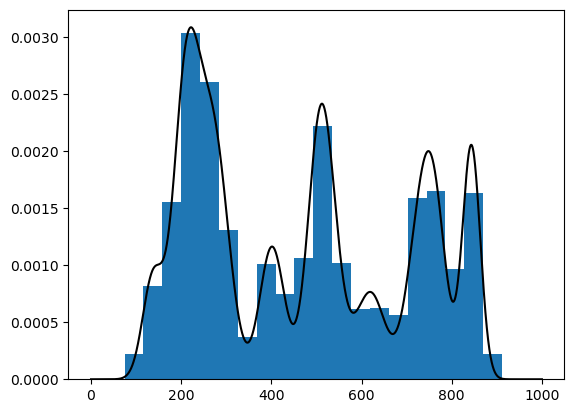

In [3]:
#integrate numerically to create approximate cdf, too lazy to invert cdf analytically
X_domain = np.linspace(0, 1000, 100000)
pdfvals = sum_of_gaussians(X_domain, random_pis, random_mus, random_sigs)
cdfvals = cumulative_trapezoid(pdfvals, X_domain, initial=0.)
cdfvals /= cdfvals.max()

#draw random values
X = np.interp(np.random.random(N_samples), cdfvals, X_domain)

plt.figure()
h = plt.hist(X, bins='fd', density=True)
plt.plot(X_domain, sum_of_gaussians(X_domain, random_pis, random_mus, random_sigs),'k')

The log-likelihood of the full mixture pdf is not easily differentiable:
$L(\vec{X},\hat{\theta}) = \prod_{i=1}^{N} \sum_{j=1}^{M} \pi_j P_j(x_i | \sigma_j, \mu_j)$

$l(\vec{X},\hat{\theta}) = \sum_{i=1}^{N} \ln{[\sum_{j=1}^{M} \pi_j P_j(x_i | \sigma_j, \mu_j)]}$

due to the sum inside the logarithm. Maybe we can write the log likelihood differently? Theres an inherent quality of each datem which we do not know a-priori, which is the specific Gaussian in the mixture it was drawn from. This is known as a latent variable, meaning it can only be determined from a reasonably good model for each Gaussian, which is what we are trying to find in the first place. Let's define this variable as $\vec{Z}$, with one entry for every sample in $\vec{X}$. Each value in $\vec{Z}$ is in the set of integers from $1$ to $M$.

$z_i \in \mathbb{Z}_M$

If $x_i$ was drawn from the $j$th Gaussian, then $z_i = j$. Thus, we can make a complete likelihood including the latent variable which eliminates the sum inside the logarithm. This is the most subtle step...

$L(\hat{\theta}; \vec{X}, \vec{Z}) = \prod_{i=1}^{N} \prod_{j=1}^{M} [\pi_j P_j(x_i | \sigma_j, \mu_j)]^{\mathbb{1}(z_i = j)}$

Where $\mathbb{1}(z_i = j)$ is the indicator function, similar to a Kronecker delta but for things other than indices, which is zero unless $z_i = j$. Thus, for each $x_i$, only one factor in the inner product over $j$ is significant: the one where $j$ is in fact the Gaussian that $x_i$ was drawn from. All other factors are raised to $0$ and thus equal to $1$ leaving the overall likelihood unchanged. The log likelihood is thus:

$l(\hat{\theta}; \vec{X}, \vec{Z}) = \sum_{i=1}^{N} \sum_{j=1}^{M} \mathbb{1}(z_i = j) \ln[\pi_j P_j(x_i | \sigma_j, \mu_j)]$

Expectation Maximization (EM) maximizes this type of likelihood (one with latent variables) by first calculating the expected value of the log likelihood at some given values for the parameters, and maximizing it instead, hence expectation maximization. This expected value, which we'll call $Q(\hat{\theta}|\hat{\theta}^{(t)})$ ($\hat{\theta}^{(t)}$ being the current guess for the parameters), is calculated as follows:

$\begin{aligned}
Q(\hat{\theta}|\hat{\theta}^{(t)}) &= E\bigl\{\sum_{i=1}^{N} \sum_{j=1}^{M} \mathbb{1}(z_i = j) \ln[\pi_j^{(t)} P_j(x_i | \sigma_j^{(t)}, \mu_j^{(t)})]\bigl\} \\
&= \sum_{i=1}^{N} E\bigl\{\sum_{j=1}^{M} \mathbb{1}(z_i = j) \ln[\pi_j^{(t)} P_j(x_i | \sigma_j^{(t)}, \mu_j^{(t)})]\bigl\}
\end{aligned}$

The expectation of the inner sum is the weighted average of the log likelihood contribution of each individual Gaussian. To calculate it, we need to know the probability that $z_i = j$. We know the value of $x_i$ and our current guess for the parameters, so how can we estimate the probability? Prior knowledge means Bayes' rule applies.

$P_{ij}(z_i=j | x_i ; \hat{\theta}_j^{(t)}) = \frac{\pi_j^{(t)} P_j(x_i | \sigma_j^{(t)}, \mu_j^{(t)})}{\sum_{k=1}^{M} \pi_k^{(t)} P_k(x_i | \sigma_k^{(t)}, \mu_k^{(t)})}$

In Bayseian speak, $pi_j^{(t)}$ is the prior probability that (any) $x_i$ is drawn from Gaussian $j$, $P_j(x_i | \sigma_j^{(t)}, \mu_j^{(t)})$ is the likelihood of $x_i$ given the current guess for the parameters. The denominator (marginal likelihood) is the total likelihood that we see the value $x_i$ from any of the Gaussians. The first step of one interation of EM is calculating these probabilities, with which we can write the expected value for the log likelihood.

$\begin{aligned}
Q(\hat{\theta}|\hat{\theta}^{(t)}) &= \sum_{i=1}^{N} \sum_{j=1}^{M} P_{ij}(z_i=j | x_i ; \hat{\theta}_j^{(t)}) \ln[\pi_j P_j(x_i | \sigma_j, \mu_j)] \\
&= \sum_{i=1}^{N} \sum_{j=1}^{M} P_{ij}(z_i=j | x_i ; \hat{\theta}_j^{(t)}) \Biggl[\ln{\pi_j} - \frac{1}{2} \ln{\sigma_j^2} - \frac{(x_i - \mu_j)^2}{2 \sigma_j^2} - \frac{1}{2}\ln{2 \pi}\Biggl]
\end{aligned}$

This expression is easily differentiable for the $j$th parameters, so an estimator can be calculated for each:

$\frac{\partial{Q}}{\partial{\mu_j}} = \sum_{i=1}^{N} P_{ij} \frac{x_i - \mu_j}{\sigma_j^2} = 0$

$\hat{\mu_j} = \frac{\sum_{i=1}^{N} P_{ij} x_i}{\sum_{i=1}^{N} P_{ij}}$

$\frac{\partial{Q}}{\partial{\sigma_j^2}} = \sum_{i=1}^{N} P_{ij} \Bigl[\frac{1}{2 \sigma_j^2} + \frac{(x_i - \mu_j)^2}{2 \sigma_j^4}\Bigl] = 0$

$\hat{\sigma_j^2} = \frac{\sum_{i=1}^{N} P_{ij} (x_i - \mu_j)^2}{\sum_{i=1}^{N} P_{ij}}$

and maximizing $\sum_{i=1}^{N} P_{ij} \ln{\pi_j}$ subject to $1 = \sum_{j=1}^{M} \pi_j$

Which is solved for $\pi_j$ using Lagrange multipliers:

$0 = \frac{\partial{Q}}{\partial{\pi_j}} - \lambda$

$\frac{\partial{Q}}{\partial{\pi_j}} = \sum_{i=1}^{N} \frac{P_{ij}}{\pi_j}$

$\lambda = \sum_{i=1}^{N} \frac{P_{ij}}{\pi_j} = \frac{1}{\pi_j} \sum_{i=1}^{N} P_{ij}$

where the sum of the $P_{ij}$s for one Gaussian is the number from the sample drawn from it:

$\sum_{i=1}^{N} P_{ij} = N_j$ and $\pi_j = \frac{N_j}{N}$

So the lagrange multiplier $\lambda$ is $N$ and:

$\hat{\pi_j} = \frac{1}{N} \sum_{i=1}^{N} P_{ij}$

The second step of EM is calculating a new estimate for all the parameters given the current values of the $P_{ij}$. Iterating through the two steps, calculating the expectation, then estimating the parameters, continually increases the log likelihood. It will approach, at the very least, a local maximum.

Let's implement this algorithm in python. To simplify things, let's say we know how many Gaussians are in the mixture a priori. We need to make an initial guess for the parameters. If there are that many distinct peaks in the historgram with Friedman-Diaconis bins, the center of those bins are a great start for the $\pi_j$'s and $\sigma_j$'s. If not, just choose evenly spaced ones between the min and max of the data. 

In [4]:
class GaussianMixture:

    def __init__(self, data: np.ndarray, npeaks: int = 10) -> None:
        self.X = data
        self.N = self.X.size
        self.npeaks = npeaks
        self.X_stretched = np.broadcast_to(self.X[:,np.newaxis], (self.X.size, self.npeaks))

        self.make_guess()

        #init pij
        self.compute_pij()

        #compute initial log-likelihood
        self.ll = self.log_likelihood()

    def make_guess(self) -> None:
        h,b = np.histogram(self.X, bins='fd')
        i = find_peaks(h)[0]
        #if all the peaks are resolvable, they are the guesses
        if i.size == self.npeaks:
            self.pis = h[i] / h[i].sum()
            self.mus = b[i] + np.diff(b)[0]/2.
        else:
            self.pis = np.ones(self.npeaks)
            self.pis /= self.pis.sum()
            self.mus = np.linspace(self.X.min(), self.X.max(), self.npeaks)
        self.sigs = np.full_like(self.mus, np.diff(self.mus)[0] / 2)
        
    def normalize_pij(self) -> None:
        self.pij /= self.pij.sum(axis=1)[:,np.newaxis]
        
    def log_likelihood(self) -> np.float64:
        return np.log(sum_of_gaussians(self.X, self.pis, self.mus, self.sigs)).sum()
    
    def compute_pij(self) -> None:
        self.pij = (self.pis * gaussian_array(self.X, self.mus, self.sigs))
        self.normalize_pij()

    def compute_pars(self) -> None:
        variances = np.empty_like(self.sigs)
        self.pis = self.pij.sum(axis=0) / self.N
        self.mus = np.average(self.X_stretched, axis=0, weights=self.pij)
        variances = np.average((self.X_stretched-self.mus)**2, weights=self.pij, axis=0)
        self.sigs = np.sqrt(variances)

    def fit(self, max_iter=10000, threshold=1.e-5) -> tuple[np.ndarray, 
                                                          np.ndarray, 
                                                          np.ndarray]:
        i = 0
        while i < max_iter:
            # print(self.ll)
            self.compute_pij()
            self.compute_pars()
            new_ll = self.log_likelihood()
            if np.isnan(new_ll):
                raise(ValueError)
            if new_ll - self.ll < threshold:
                return self.pis, self.mus, self.sigs
            self.ll = new_ll
            i += 1
        return self.pis, self.mus, self.sigs

In [5]:
gm = GaussianMixture(X,N_gaussians)

In [6]:
pis, mus, sigmas = gm.fit(10000,1.e-5)

In [7]:
random_sigs

array([23.02082227, 28.52715976, 33.57960387, 27.03119411, 32.92723144,
       25.6981552 , 31.37954633, 32.60284276, 25.7888041 , 19.71201178])

In [8]:
sigmas

array([22.72883035, 35.56088313, 26.05096544, 30.58707904, 26.34490134,
       29.68147462, 34.51045906, 28.30229147, 22.35296374, 20.91747927])

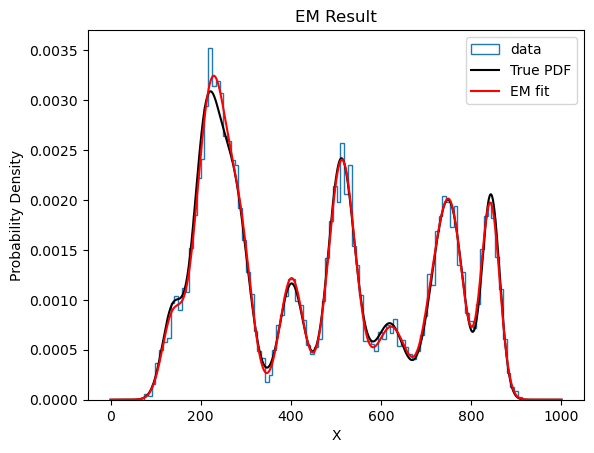

In [9]:
plt.figure()
h = plt.hist(X, bins=100, density=True, histtype='step', label='data')
plt.plot(X_domain, sum_of_gaussians(X_domain, random_pis, random_mus, random_sigs),'k', label='True PDF')
plt.plot(X_domain, sum_of_gaussians(X_domain, pis, mus, sigmas),'r', label = 'EM fit')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.title('EM Result')
plt.legend()